This code was run in Google Colab and the datasets were downloaded manually from http://odds.cs.stonybrook.edu/.

In [14]:
!pip install ipython-autotime

time: 6.03 s (started: 2023-08-06 21:45:59 +00:00)


In [15]:
import numpy as np
from scipy.io import loadmat

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import NearestNeighbors

import math
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score, confusion_matrix, RocCurveDisplay

time: 1.06 ms (started: 2023-08-06 21:46:05 +00:00)


In [16]:
def obliczanie_y_pred(pojedynczy_model_do_oceny, pojedynczy_zbior_danych, metric_kind):

  algorithm_name = type(pojedynczy_model_do_oceny).__name__
  X, y = get_data(pojedynczy_zbior_danych)

  if metric_kind == 'roc':
      pojedynczy_model_do_oceny.fit(X)

      if algorithm_name == 'LocalOutlierFactor':
          y_pred = pojedynczy_model_do_oceny.negative_outlier_factor_
      else:
          y_pred = pojedynczy_model_do_oceny.decision_function(X)

  if metric_kind == 'conf_matrix':
      y_pred = pojedynczy_model_do_oceny.fit_predict(X)
      y_pred[y_pred==1] = 0    # inliers
      y_pred[y_pred==-1] = 1   # outliers

  return y_pred


time: 965 µs (started: 2023-08-06 21:46:05 +00:00)


In [17]:
def ocena_pojedyncza(pojedynczy_model_do_oceny, pojedynczy_zbior_danych, metric_kind):

  algorithm_name = type(pojedynczy_model_do_oceny).__name__
  y_pred = obliczanie_y_pred(pojedynczy_model_do_oceny, pojedynczy_zbior_danych, metric_kind)
  X, y = get_data(pojedynczy_zbior_danych)

  if metric_kind == 'roc':

      RocCurveDisplay.from_predictions(
          y,
          y_pred,
          name=algorithm_name,
          color="darkorange",
          pos_label=0
      )
      plt.plot([0, 1], [0, 1], "k--")
      plt.axis("square")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title(f"{algorithm_name}, {pojedynczy_zbior_danych}")
      plt.legend()
      plt.show()

  if metric_kind == 'conf_matrix':

      print(f'Confussion matrix dla algorytmu {algorithm_name} dla zbioru {pojedynczy_zbior_danych}:\n{confusion_matrix(y, y_pred)}')


time: 1.16 ms (started: 2023-08-06 21:46:05 +00:00)


In [18]:
# DISPLAY RESULTS FOR ALL MODELS AT ONCE
def malowanie_wszytskich():

  fig, axs = plt.subplots(3, 1, figsize=(6, 3 * 3))

  for i, dataset_name in enumerate(zbiory):
      X, y = get_data(dataset_name)

      for model_name in modele:

          model = daj_model_z_best_parms(model_name, dataset_name)

          y_pred = obliczanie_y_pred(model, dataset_name, 'roc')

          display = RocCurveDisplay.from_predictions(
              y,
              y_pred,
              pos_label=0,
              name=model_name,
              linewidth=1,
              ax=axs[i],
          )
          axs[i].plot([0, 1], [0, 1], linewidth=1, linestyle=":")
          axs[i].set_title(dataset_name)
          axs[i].set_xlabel("False Positive Rate")
          axs[i].set_ylabel("True Positive Rate")

          ocena_pojedyncza(model, dataset_name, 'conf_matrix')

  plt.tight_layout(pad=2.0)  # spacing between subplots

  plt.show()



time: 2.3 ms (started: 2023-08-06 21:46:05 +00:00)


In [19]:
# DATASETS DOWNLOADING
def get_data(dataset_name):

    if dataset_name == "mammography":
        f = loadmat(r'/content/mammography.mat')

    if dataset_name == "arrhythmia":
        f = loadmat(r'/content/arrhythmia.mat')

    if dataset_name == "ionosphere":
        f = loadmat(r'/content/ionosphere.mat')

    X = f['X']
    y = f['y']

    return X, y

time: 777 µs (started: 2023-08-06 21:46:05 +00:00)


In [20]:
def choose_model(model_name):
    if model_name == 'svm':
        model = OneClassSVM()
        param_grid = {
            'kernel': ['linear', 'rbf', 'sigmoid'],
            'nu': [0.01, 0.3, 0.9],
            'gamma': ['scale', 'auto']
        }
    elif model_name == 'iforest':
        model = IsolationForest()
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_samples': ['auto', 200],
            'contamination': [0.01, 0.2, 0.5],
            'random_state': [42]
        }
    elif model_name == 'mahalanobis':
        model = EllipticEnvelope()
        param_grid = {
            'contamination': [0.01, 0.2, 0.5],
            'support_fraction': [0.1, 0.5, 0.9],
            'store_precision': [True, False],
            'random_state': [42]
        }
    else:
        raise ValueError("Nieznany model")

    return {'model': model, 'param_grid': param_grid}

time: 1.13 ms (started: 2023-08-06 21:46:05 +00:00)


In [21]:
def tune_model(dataset_name, model, param_grid, tuning_method):

  # selecting scoring for each dataset
    if dataset_name == 'mammography':
        scoring = [
            'roc_auc',
            'accuracy',
            'average_precision',
            'neg_mean_squared_error',
            'neg_mean_absolute_error'
        ]

    elif dataset_name == 'ionosphere':
        scoring = [

            'accuracy',
            'average_precision',
            'neg_mean_squared_error',
            'neg_mean_absolute_error'
        ]

    elif dataset_name == 'arrhythmia':
        scoring = [
            'roc_auc',
            'accuracy',
            'average_precision',
            'neg_mean_squared_error',
            'neg_mean_absolute_error'
        ]

    # cv = KFold(n_splits=10, shuffle=True, random_state=42)
    cv = 5

    if tuning_method == 'grid':
        search = GridSearchCV(model, param_grid, scoring=scoring, refit='accuracy', cv=cv)
    elif tuning_method == 'random':
        search = RandomizedSearchCV(model, param_grid, scoring=scoring, refit='accuracy', cv=cv, n_iter=10, random_state = 42)

    data = get_data(dataset_name)
    search.fit(data[0], data[1])  # (X,y)

    searched_best_model = search.best_estimator_
    searched_best_params = search.best_params_
    searched_best_score = search.best_score_

    return {'searched_best_model': searched_best_model, 'searched_best_params': searched_best_params, 'searched_best_score': searched_best_score}

time: 1.22 ms (started: 2023-08-06 21:46:05 +00:00)


In [22]:
def daj_model_z_best_parms(ktory_model, ktory_zbior):
    # choose model
    selected_model_info = choose_model(ktory_model)
    selected_model = selected_model_info['model']
    selected_model_param_grid = selected_model_info['param_grid']

    # choose dataset
    selected_dataset = ktory_zbior

    # choose tuning method
    search_types = ['grid', 'random']
    i = 0

    for search_type in search_types:
        aktualne_model_info = tune_model(selected_dataset, selected_model, selected_model_param_grid, search_type)

        if i == 0:
          pierwsze_model_info = aktualne_model_info

          model_info = pierwsze_model_info

          koniec_zdania = 'wszystkich metod tuningu'

          # print(search_type, '1 iteracja', pierwsze_model_info['searched_best_params'])
        else:
          # print(search_type, '2 iteracja', aktualne_model_info['searched_best_params'])

          if pierwsze_model_info['searched_best_params'] == aktualne_model_info['searched_best_params']:
              continue

          else:
            if pierwsze_model_info['searched_best_score'] < aktualne_model_info['searched_best_score']:

              model_info = aktualne_model_info

              deciding_score = model_info['searched_best_score']
              koniec_zdania = f'metody tuningu {search_type}, ktora uzyskała lepszy wynik .best_score_ = {deciding_score}'

            else:

              deciding_score = model_info['searched_best_score']
              koniec_zdania = f'metody tuningu {search_types[0]}, ktora uzyskała lepszy wynik .best_score_ = {deciding_score}'

        i+=1

    best_model = model_info['searched_best_model']
    best_param_grid = model_info['searched_best_params']

    # print(f'Najlepsze hiperparametry:\n{best_param_grid}\nwedług {koniec_zdania}, dla modelu {ktory_model} do zbioru {ktory_zbior}.')

    return best_model

time: 1.29 ms (started: 2023-08-06 21:46:05 +00:00)


In [23]:
modele = ['svm', 'iforest', 'mahalanobis']
zbiory = ['mammography', 'ionosphere', 'arrhythmia']
ktore_ocenienie = ['roc', 'conf_matrix']

time: 838 µs (started: 2023-08-06 21:46:05 +00:00)


In [24]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.42 ms (started: 2023-08-06 21:46:05 +00:00)


In [25]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

time: 627 µs (started: 2023-08-06 21:46:05 +00:00)


Confussion matrix dla algorytmu OneClassSVM dla zbioru mammography:
[[10841    82]
 [  247    13]]
Confussion matrix dla algorytmu IsolationForest dla zbioru mammography:
[[10845    78]
 [  226    34]]
Confussion matrix dla algorytmu EllipticEnvelope dla zbioru mammography:
[[10812   111]
 [  259     1]]
Confussion matrix dla algorytmu OneClassSVM dla zbioru ionosphere:
[[223   2]
 [124   2]]
Confussion matrix dla algorytmu IsolationForest dla zbioru ionosphere:
[[225   0]
 [122   4]]
Confussion matrix dla algorytmu EllipticEnvelope dla zbioru ionosphere:
[[225   0]
 [122   4]]
Confussion matrix dla algorytmu OneClassSVM dla zbioru arrhythmia:
[[385   1]
 [ 63   3]]
Confussion matrix dla algorytmu IsolationForest dla zbioru arrhythmia:
[[384   2]
 [ 63   3]]
Confussion matrix dla algorytmu EllipticEnvelope dla zbioru arrhythmia:
[[382   4]
 [ 65   1]]


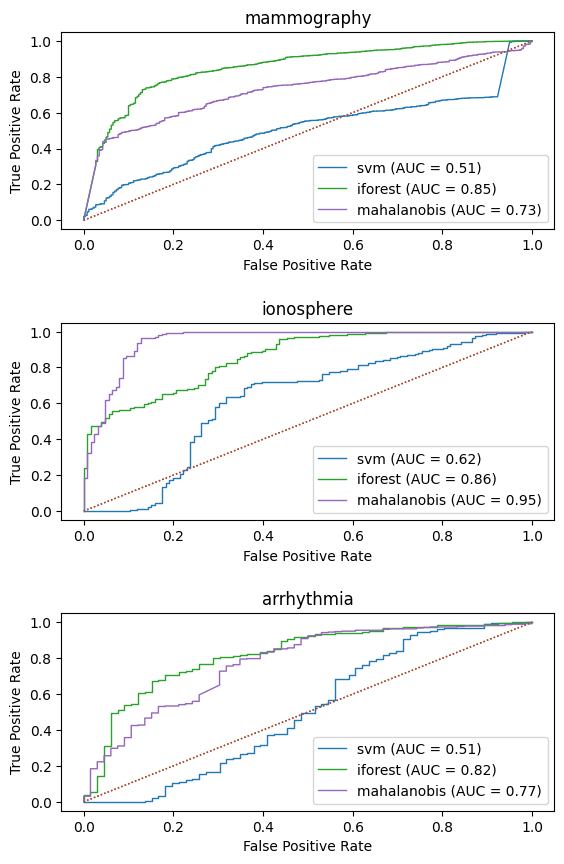

time: 25min 45s (started: 2023-08-06 21:47:37 +00:00)


In [27]:
malowanie_wszytskich()

Algorithm performance refers to how good the true positive rate (TPR) is with a low false positive rate (FPR). The best algorithms have a curve in the upper left corner of the graph, and the area under the curve (AUC) is close to 1. The diagonal dashed line shows a random classification of outliers and inliers.

In the confusion matrix the data is presented as following:

[[true negatives, false positives]

  [false negatives, true positives]]

Sensitivity is the probability of a positive test result based on whether a given sample is truly positive (in this case, whether it is an anomaly). In other words, it is the ratio of true positives to the sum of true positives and false negatives.
Specificity is the probability of a negative test result based on whether a given sample is truly negative (in this case, an anomaly). In other words, it is the ratio of true negatives to the sum of true negatives and false positives.

An example of results interpretation is presented for OneClassSVM and "Mammogrphy" dataset. This dataset contains 11,183 samples, including 260 anomalies.
* 10,841 true negatives (normal samples correctly classified as normal),
* 82 results are false positives (normal samples misclassified as anomalies),
* 247 results are false negatives (anomalies misclassified as normal),
* 13 are true positives (anomalies correctly classified as anomalies).

Results indicate:

Algorithm sensitivity = 13/(13+247) = 0.05

Algorithm specificity = 10841/(10841+82) = 0.992

This means that the model detected only 5% of the true positive samples (anomalies) out of all the samples in the dataset. And so it has very great difficulty in detecting anomalies (for this dataset). The model correctly classified 99.2% of the true negative samples (non-anomalies), so it is efficient in identifying non-anomalous samples. In conclusion, the SVM with choosen hyperparameters is not suitable for the "Mammography" dataset, because it hardly detects anomalies at all.